In [1]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import f_oneway
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier, early_stopping
from catboost import CatBoostClassifier

SEED = 42
plt.style.use("ggplot")
pd.options.display.max_columns = None

## 1. Data

In [2]:
path = "data/"
train_df = pd.read_csv(path+"train.csv")
test_df = pd.read_csv(path+"test.csv")
ss_df = pd.read_csv(path+"SampleSubmission.csv")

In [3]:
print(f"Train Shape: {train_df.shape}\nTest Shape: {test_df.shape}\nSubmission: {ss_df.shape}")

Train Shape: (823053, 13)
Test Shape: (174723, 12)
Submission: (1932, 2)


In [4]:
print("\t\t\t\t\t Tain set:")
display(train_df.head())
print("\t\t\t\t\t Test set:")
display(test_df.head())
print("\t\t\t\t\t Submisssion set:")
display(ss_df.head())

					 Tain set:


,NE,endTime,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,ID,NE_ID,target
0,B0010-72,2023-02-09 01:00:00,1.025,3.389423,10.727969,7.492512,3.002243,17.988247,0.0,0.0,1,B0010-72_1,0
1,B0010-72,2023-02-09 02:00:00,0.854,3.006494,8.157557,7.882693,1.758560,12.360708,0.0,0.0,1,B0010-72_1,0
2,B0010-72,2023-02-09 03:00:00,0.819,3.307018,17.902962,7.672714,1.140774,10.075042,0.0,0.0,1,B0010-72_1,0
3,B0010-72,2023-02-09 04:00:00,0.823,2.185185,8.175228,7.193010,2.903567,21.281706,0.0,0.0,1,B0010-72_1,0
4,B0010-72,2023-02-09 05:00:00,0.893,2.350515,7.645895,8.975481,5.679832,16.526131,0.0,0.0,1,B0010-72_1,0


					 Test set:


,NE,endTime,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,ID,NE_ID
0,B0017-32,2023-02-19 11:00:00,60.941,2.727843,12.841164,6.161731,6.602028,3.161234,0.0,0.0,10,B0017-32_10
1,B0017-32,2023-02-19 12:00:00,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,10,B0017-32_10
2,B0073-45,2023-02-19 13:00:00,8.294,2.357810,9.107972,7.166678,6.187408,6.932266,0.0,0.0,24,B0073-45_24
3,B0073-45,2023-02-19 14:00:00,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,24,B0073-45_24
4,B0093-23,2023-02-19 19:00:00,56.760,1.037665,11.913121,8.925502,11.309321,25.287751,0.0,0.0,21,B0093-23_21


					 Submisssion set:


,ID,data_rate_t+1_trend
0,B0017-25_24,0
1,B0017-25_25,0
2,B0017-25_26,0
3,B0017-25_27,0
4,B0017-32_1,0


In [5]:
# Feature formatting
train_df["endTime"] = pd.to_datetime(train_df["endTime"])
test_df["endTime"] = pd.to_datetime(test_df["endTime"])

## 2. Preprocessing

In [6]:
print("\t\t\t\t\t Descrptive Stats Train")
display(train_df.describe())

print("\t\t\t\t\t Descrptive Stats Test")
display(test_df.describe())

					 Descrptive Stats Train


,endTime,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,ID,target
count,823053,823053.000000,823053.000000,823053.000000,823053.000000,823053.000000,823053.000000,823053.000000,823053.000000,823053.000000,823053.000000
mean,2023-02-16 14:43:02.892718336,22.677920,1.877105,9.978879,8.020528,8.282708,17.888637,6.261322,-0.006015,1.864541,0.005751
min,2023-02-09 01:00:00,-66.224834,-1.000000,-30.397039,-1.000000,-10.912284,-1.000000,-1.000000,-7.341916,1.000000,0.000000
25%,2023-02-12 06:00:00,4.950000,1.205684,8.337656,6.810197,6.501982,6.261243,0.000000,0.000000,1.000000,0.000000
50%,2023-02-15 22:00:00,14.691489,1.626305,10.353433,7.972291,8.435527,12.728668,0.000000,0.000000,1.000000,0.000000
75%,2023-02-20 04:00:00,33.536000,2.193225,11.712354,9.387695,10.297619,24.209245,0.000000,0.000000,1.000000,0.000000
max,2023-03-02 00:00:00,444.783631,7.031414,100.000000,22.811374,27.970290,430.021258,3600.000000,1.000000,42.000000,1.000000
std,NaN,22.693393,1.210995,4.738515,2.544488,3.504649,17.000900,135.715680,0.107781,3.382459,0.075614


					 Descrptive Stats Test


,endTime,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,ID
count,174723,174723.000000,174723.000000,174723.000000,174723.000000,174723.000000,174723.000000,174723.000000,174723.000000,174723.000000
mean,2023-02-17 01:51:55.660788736,22.106585,1.443846,9.773660,7.999823,8.339066,17.256321,-0.011058,-0.011058,2.133102
min,2023-02-09 01:00:00,-1.000000,-1.000000,-85.543872,-1.000000,-1.000000,-3098.010849,-1.000000,-1.000000,1.000000
25%,2023-02-12 12:00:00,5.174000,1.032511,8.275060,6.952626,6.785581,6.802925,0.000000,0.000000,1.000000
50%,2023-02-16 09:00:00,14.682000,1.371320,10.213715,7.996416,8.628030,13.344623,0.000000,0.000000,1.000000
75%,2023-02-21 01:00:00,32.544000,1.832772,11.492089,9.170333,10.300283,23.746967,0.000000,0.000000,1.000000
max,2023-03-01 02:00:00,99.582979,7.000000,100.000000,15.000000,27.287647,445.511018,0.000000,0.000000,43.000000
std,NaN,21.787419,0.724781,4.213319,2.369982,3.314442,21.232004,0.104572,0.104572,4.211539


In [7]:
# "relation" have to be negative values
train_df.loc[train_df.relation<0, "relation"] = 0
test_df.loc[test_df.relation<0, "relation"] = 0

### Check if all NE in test belong in train set

In [8]:
tmp = train_df[train_df.NE_ID.isin(test_df.NE_ID)]
print(f"There is {tmp.NE_ID.unique().shape[0]} network element in the test set which belong in train set")

There is 0 network element in the test set which belong in train set


In [9]:
tmp = train_df[train_df.NE.isin(test_df.NE)]
print(f"There is {tmp.NE.unique().shape[0]} network in the test set which belong in train set. That network is {tmp.NE.unique()[0]}")

There is 1 network in the test set which belong in train set. That network is B0017-25


# We assumed that: the state at timestep t+1 only depends on the previous 6 timesteps (t-5, t-4, t-3, t-2, t-1, t)

### Let's keep only the last 7 timetsep in each NE_ID

In [10]:
def delete_zero(df, thres=7, n_rows_tokeep=7):
    
    # Keep NE which have less than 30 days
    new_df = pd.DataFrame()
    tmp = df.groupby("NE_ID").count()["NE"].sort_values(ascending=False)
    ne_ids = tmp[tmp.values<=thres].index.tolist()
    new_df = df[df.NE_ID.isin(ne_ids)].copy()
    
    # Delete 
    ne_ids = tmp[tmp.values>thres].index.tolist()

    for ne_id in tqdm(ne_ids):
        new_df = pd.concat((new_df, df[df.NE_ID==ne_id][-n_rows_tokeep:]))

    return new_df

In [11]:
train_df.target.value_counts()

target
0    818320
1      4733
Name: count, dtype: int64

In [12]:
train_df = delete_zero(train_df.copy())
train_df.target.value_counts()

100%|███████████████████████████████████████| 5411/5411 [17:25<00:00,  5.18it/s]


target
0    39826
1     4733
Name: count, dtype: int64

In [13]:
test_df = delete_zero(test_df.copy())
test_df.shape

100%|███████████████████████████████████████| 1222/1222 [00:57<00:00, 21.33it/s]


(10719, 12)

In [14]:
def lag_features(df, cols, shifts):
    
    for shift in shifts:
        for col in cols:
            df = df.merge(
                    df.groupby("NE_ID")[col].\
                          shift(shift).\
                          to_frame().\
                          rename(columns={col:col+"_lag-"+str(shift)}),
                    left_index=True, right_index=True
                 )
            
            if shift >= 2 and col not in ["fault_duration", "relation"]:
                df["diff_lag_"+col+str(shift)+"_"+str(shift-1)] =  df[col+"_lag-"+str(shift)] - df[col+"_lag-"+str(shift-1)]
            
            if shift == 3 and col not in ["fault_duration", "relation"]:
                df["diff_lag_"+col+str(shift)+"_"+str(shift-2)] =  df[col+"_lag-"+str(shift)] - df[col+"_lag-"+str(shift-2)]
            
    return df

In [15]:
dels = [col for col in train_df.columns if "lag" in col]
train_df.drop(dels, axis=1, inplace=True)
test_df.drop(dels, axis=1, inplace=True)

In [16]:
# cols = ["TA", "bler", "cqi", "mcs"]
cols= ["resource_utilition_rate", "data_rate", "fault_duration", "relation"]
shifts = [1, 2, 3]
train_df = lag_features(train_df.copy(), cols, shifts)
test_df = lag_features(test_df.copy(), cols, shifts)

In [17]:
train_df = train_df.fillna(0)
tet_df = test_df.fillna(0)

In [18]:
train_df.head()

,NE,endTime,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,ID,NE_ID,target,resource_utilition_rate_lag-1,data_rate_lag-1,fault_duration_lag-1,relation_lag-1,resource_utilition_rate_lag-2,diff_lag_resource_utilition_rate2_1,data_rate_lag-2,diff_lag_data_rate2_1,fault_duration_lag-2,relation_lag-2,resource_utilition_rate_lag-3,diff_lag_resource_utilition_rate3_2,diff_lag_resource_utilition_rate3_1,data_rate_lag-3,diff_lag_data_rate3_2,diff_lag_data_rate3_1,fault_duration_lag-3,relation_lag-3
660,B0679-23,2023-02-18 04:00:00,0.803,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,17,B0679-23_17,0,0.000,0.000000,0.0,0.0,0.000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
661,B0679-23,2023-02-18 08:00:00,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.0,17,B0679-23_17,0,0.803,0.000000,0.0,0.0,0.000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
980,B0017-23,2023-02-16 19:00:00,97.655,2.218162,15.780840,6.321792,5.562886,1.120358,0.0,0.0,6,B0017-23_6,0,0.000,0.000000,0.0,0.0,0.000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
981,B0017-23,2023-02-16 20:00:00,91.368,2.293010,14.717525,6.562809,6.302848,2.605797,0.0,0.0,6,B0017-23_6,0,97.655,1.120358,0.0,0.0,0.000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
982,B0017-23,2023-02-16 21:00:00,85.500,2.468289,14.091530,6.638226,6.375721,3.797321,0.0,0.0,6,B0017-23_6,0,91.368,2.605797,0.0,0.0,97.655,6.287,1.120358,-1.485439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
def fe_time(df): 
    df["month"] = df["endTime"].dt.month
    df["day"] = df["endTime"].dt.day
    df["dayow"] = df["endTime"].dt.dayofweek
    df["hour"] = df["endTime"].dt.hour
    
    return df

In [20]:
train_df = fe_time(train_df.copy())
test_df = fe_time(test_df.copy())

In [21]:
train_df = train_df.reset_index(drop=True).sort_values(["NE_ID", "endTime"])
test_df = test_df.reset_index(drop=True).sort_values(["NE_ID", "endTime"])

In [22]:
nes_tr = set([value for value in train_df.NE.unique()])
nes_te = set([value for value in test_df.NE.unique()])
nes = nes_tr.union(nes_te)
ids = [i for i in range(0, len(nes))]

mappe = {}
for k, v in tqdm(zip(nes, ids)):
    mappe[k] = v

train_df['NE'] = train_df['NE'].replace(mappe)
test_df['NE'] = test_df['NE'].replace(mappe)

3440it [00:00, 445307.42it/s]


## 3. Split Data for Train and Test

In [23]:
train_df.columns

Index(['NE', 'endTime', 'resource_utilition_rate', 'TA', 'bler', 'cqi', 'mcs',
       'data_rate', 'fault_duration', 'relation', 'ID', 'NE_ID', 'target',
       'resource_utilition_rate_lag-1', 'data_rate_lag-1',
       'fault_duration_lag-1', 'relation_lag-1',
       'resource_utilition_rate_lag-2', 'diff_lag_resource_utilition_rate2_1',
       'data_rate_lag-2', 'diff_lag_data_rate2_1', 'fault_duration_lag-2',
       'relation_lag-2', 'resource_utilition_rate_lag-3',
       'diff_lag_resource_utilition_rate3_2',
       'diff_lag_resource_utilition_rate3_1', 'data_rate_lag-3',
       'diff_lag_data_rate3_2', 'diff_lag_data_rate3_1',
       'fault_duration_lag-3', 'relation_lag-3', 'month', 'day', 'dayow',
       'hour'],
      dtype='object')

In [24]:
main_cols = train_df.columns.difference(["NE_ID", "NE", "ID", "endTime", "target"])
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [25]:
train_df[main_cols].head()

,TA,bler,cqi,data_rate,data_rate_lag-1,data_rate_lag-2,data_rate_lag-3,day,dayow,diff_lag_data_rate2_1,diff_lag_data_rate3_1,diff_lag_data_rate3_2,diff_lag_resource_utilition_rate2_1,diff_lag_resource_utilition_rate3_1,diff_lag_resource_utilition_rate3_2,fault_duration,fault_duration_lag-1,fault_duration_lag-2,fault_duration_lag-3,hour,mcs,month,relation,relation_lag-1,relation_lag-2,relation_lag-3,resource_utilition_rate,resource_utilition_rate_lag-1,resource_utilition_rate_lag-2,resource_utilition_rate_lag-3
15677,0.791429,5.649885,8.967102,23.821005,0.000000,0.000000,0.000000,20,0,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,7,6.466847,2,0.0,0.0,0.0,0.0,7.398,0.000,0.000,0.000
15678,0.760908,7.383906,8.853353,39.898652,23.821005,0.000000,0.000000,20,0,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,8,10.120364,2,0.0,0.0,0.0,0.0,10.877,7.398,0.000,0.000
15679,0.754630,9.543981,8.789539,38.502784,39.898652,23.821005,0.000000,20,0,-16.077647,0.000000,0.000000,-3.479,0.000,0.000,0.0,0.0,0.0,0.0,9,13.537159,2,0.0,0.0,0.0,0.0,16.023,10.877,7.398,0.000
15680,0.759430,10.249399,8.600942,24.524838,38.502784,39.898652,23.821005,20,0,1.395868,-14.681779,-16.077647,-5.146,-8.625,-3.479,0.0,0.0,0.0,0.0,10,12.360695,2,0.0,0.0,0.0,0.0,45.113,16.023,10.877,7.398
15681,0.811247,10.261306,8.565688,21.864610,24.524838,38.502784,39.898652,20,0,13.977946,15.373814,1.395868,-29.090,-34.236,-5.146,0.0,0.0,0.0,0.0,11,12.344837,2,0.0,0.0,0.0,0.0,45.419,45.113,16.023,10.877


In [26]:
def get_ne_id_train_val(train_df=None, k=None, seed=None, isval=True):
    ne_ids_fold = []
    ne_ids_1 = train_df[train_df.target==1]["NE_ID"].sample(frac=1, random_state=seed).unique()
    ne_ids_0 = train_df[~train_df.NE_ID.isin(ne_ids_1)]["NE_ID"].sample(frac=1, random_state=seed).unique()
    
    tmp1 = np.array_split(ne_ids_1, k)
    tmp0 = np.array_split(ne_ids_0, k)

    tmp = []
    for fold in range(0, k):
        tmp.append(np.concatenate((tmp0[fold], tmp1[fold]), axis=0))
    
    if isval == True:
        n_val = len(tmp) // k
        for fold in range(0, k):
            trn = np.concatenate( 
                    (tmp[:fold * n_val]+
                     tmp[(fold + 1) * n_val:]
                    ),
                    axis=0
                  )
            val = np.array(tmp[fold * n_val: (fold + 1) * n_val]).flatten()
            ne_ids_fold.append((trn, val))

        return ne_ids_fold
    else:
        ne_id_tr = None 
        for value in tmp[1:]:
            ne_id_tr = np.hstack((ne_id_tr, value))

        ne_ids_fold.append((ne_id_tr, tmp[0]))

        return ne_ids_fold

In [27]:
def test_data(train_df=None, k=None, fold=None, seed=None):
    ne_ids_train = get_ne_id_train_val(train_df, k, seed)        
    X_train = train_df[train_df.NE_ID.isin(ne_ids_train[fold][0])]
    X_val = train_df[train_df.NE_ID.isin(ne_ids_train[fold][1])]
    
    return X_train, X_val

new_train_df, new_test_df = test_data(train_df=train_df.copy(), k=4, fold=0, seed=42)
new_train_df.shape, new_test_df.shape

((33242, 35), (11317, 35))

In [28]:
def split_data(train_df=None, k=None, fold=None, seed=None, ne_ids_train=None):
    train = train_df[train_df.NE_ID.isin(ne_ids_train[fold][0])]
    val = train_df[train_df.NE_ID.isin(ne_ids_train[fold][1])]
    
    return train, val

In [29]:
def get_df_last_timestep(df):
    tmp = df.groupby("NE_ID").max()['endTime'].to_frame()
    new_tmp = df.merge(tmp, on=["NE_ID", 'endTime'])
    
    return new_tmp

## 4. Modeling

In [30]:
def xgb_f1(y_proba, y_true, threshold=0.5):
    y_true = y_true.get_label()
    y_cls_preds = (y_proba >= threshold).astype(int)
    
    return 'f1', f1_score(y_true, y_cls_preds)

In [31]:
def oof(name=None, clf=None, train_df=None, test_df=None, n_fold=None, seed=None):
    
    oofs  = None
    y_oof = None
    test_predictions = None
    ne_ids_train = get_ne_id_train_val(train_df.copy(), n_fold, seed, isval=True)        
    
    for fold in range(0, n_fold):
        train, val = split_data(train_df=train_df.copy(),
                                k=n_fold,
                                fold=fold,
                                seed=seed,
                                ne_ids_train=ne_ids_train)
        
        ne_ids_dev = get_ne_id_train_val(train_df=train_df[train_df.NE_ID.isin(train.NE_ID.unique())],
                                         k=n_fold, seed=seed, isval=False)
        train = train_df[train_df.NE_ID.isin(ne_ids_dev[0][0])].copy()
        dev = train_df[train_df.NE_ID.isin(ne_ids_dev[0][1])].copy()

#         train = train.sample(frac=1, random_state=seed).reset_index(drop=True)
#         dev = dev.sample(frac=1, random_state=seed).reset_index(drop=True)
#         val = val.sample(frac=1, random_state=seed).reset_index(drop=True)
  
        if name == "CAB":
            clf.fit(train[main_cols], train['target'], eval_set=[(dev[main_cols], dev['target'])],
                    early_stopping_rounds=200)

        elif name == 'LGB':
            stopping = early_stopping(stopping_rounds=100, first_metric_only=False, verbose=False)
            clf.fit(train[main_cols], train["target"], eval_set=[(dev[main_cols], dev["target"])],
                    callbacks=[stopping])    

        elif name == 'XGB':
            sample_weight = compute_sample_weight(class_weight='balanced', y=train["target"])
            clf.fit(train[main_cols], train["target"], eval_set=[(dev[main_cols], dev["target"])],
                    verbose=0) # eval_metric=xgb_f1

        else:
                clf.fit(pd.concat((train[main_cols], dev[main_cols])),
                        pd.concat((train["target"], dev["target"])))

      
        vp = clf.predict_proba(val[main_cols])[:,1]
        val["data_rate_t+1_trend"] = vp
        vp = get_df_last_timestep(val.copy())["data_rate_t+1_trend"].values
        y_val = get_df_last_timestep(val.copy())['target'].values
        
        if oofs is None:
            oofs   = np.where(vp>0.5, 1, 0)
            y_oofs = y_val
        else:
            oofs   = np.hstack((oofs, np.where(vp>0.5, 1, 0)))
            y_oofs = np.hstack((y_oofs, y_val))
        
        val_score = f1_score(y_val, np.where(vp>0.5, 1, 0))
        
        print(f'Fold {fold} Val score: {val_score:.4f}')
#         print(classification_report(y_val, np.where(vp>0.5, 1, 0)))
        print(4*'-- -- -- --')

        tp = clf.predict_proba(test_df[main_cols]) / n_fold
        if test_predictions is None:
            test_predictions = tp
        else:
            test_predictions += tp

    print(3*'###',10*"^",3*'###')
    score = f1_score(y_oofs, oofs)
    print(f"{name}: {score:.4f}")
    
    return test_predictions[:, 1], score

In [32]:
xgb = XGBClassifier(n_estimators=50, random_state=SEED)
lgb = LGBMClassifier(n_estimators=50, random_state=SEED)
cab = CatBoostClassifier(n_estimators=100, verbose=0, use_best_model=True, random_state=SEED)

In [33]:
def seeding_oof(name, model, seeds, n_fold):
    oof_preds = None
    scores = []
    for seed in seeds:
        print(4*'+++++++++')
        print(f"SEED:{seed}")
        print(4*'+++++++++')
        tmp_preds, tmp_score = oof(name=name, clf=model, train_df=train_df.copy(),
                                   test_df=test_df.copy(), n_fold=n_fold, seed=seed)
        if oof_preds is None:
            oof_preds = tmp_preds / len(seeds)
        else:
            oof_preds += tmp_preds / len(seeds)
        scores.append(tmp_score)

    print(4*'+++++++++')
    score = np.mean(scores)
    print(f"MEAN {name}: {score:.4f}")
    print(4*'+++++++++')
    return oof_preds, score

In [34]:
%%time
k = 5
model = ["XGB", xgb]
seeds = [42] # [7, 13, 17, 31, 42]
oof_preds, score = seeding_oof(model[0], model[1], seeds, n_fold=k)

++++++++++++++++++++++++++++++++++++
SEED:42
++++++++++++++++++++++++++++++++++++
Fold 0 Val score: 0.8010
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
Fold 1 Val score: 0.8037
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
Fold 2 Val score: 0.8161
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
Fold 3 Val score: 0.8064
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
Fold 4 Val score: 0.7953
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
######### ^^^^^^^^^^ #########
XGB: 0.8045
++++++++++++++++++++++++++++++++++++
MEAN XGB: 0.8045
++++++++++++++++++++++++++++++++++++
CPU times: user 1min 20s, sys: 379 ms, total: 1min 21s
Wall time: 22.2 s


## 5.  Submission

[5.3158594e-05 8.2366198e-05 7.7858902e-05 ... 5.5641794e-05 5.6731085e-05
 8.2826906e-01]


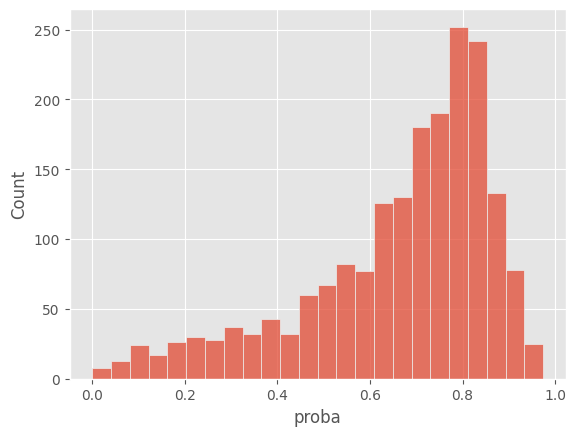

In [36]:
print(oof_preds)

test_df["proba"] = oof_preds
sns.histplot(get_df_last_timestep(test_df)["proba"])
plt.show()

In [37]:
predictions = np.where(oof_preds>0.5, 1, 0)
test_df["data_rate_t+1_trend"] = predictions
predictions.sum()

1565

In [38]:
tmp = get_df_last_timestep(test_df.copy())
tmp = tmp[["NE_ID", "data_rate_t+1_trend"]].rename(columns={"NE_ID":"ID"})
ss_df = tmp.reset_index(drop=True)

In [39]:
lenght = len(ss_df[ss_df["data_rate_t+1_trend"]==1])
ss_df.to_csv(f"oof_seeds-{seeds}_clf-{model[0]}_count1-{lenght}-cv-{score:.4f}.csv", index=False)
ss_df

,ID,data_rate_t+1_trend
0,B0017-25_24,1
1,B0017-25_25,0
2,B0017-25_26,0
3,B0017-25_27,1
4,B0017-32_1,1
...,...,...
1927,B0122-43_1,0
1928,B0122-43_2,1
1929,B0122-45_1,0
1930,B0122-45_2,1


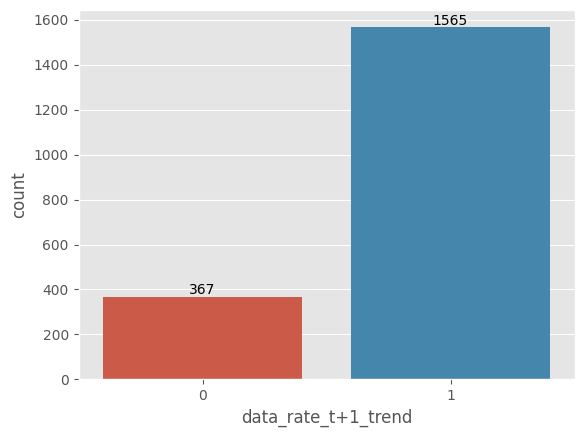

In [40]:
ax = sns.countplot(data=ss_df, x='data_rate_t+1_trend')
ax.bar_label(ax.containers[0])
plt.show()

In [41]:
ss_df[ss_df["data_rate_t+1_trend"]==0]

,ID,data_rate_t+1_trend
1,B0017-25_25,0
2,B0017-25_26,0
10,B0017-32_15,0
28,B0017-33_15,0
42,B0017-35_11,0
...,...,...
1900,B0119-13_7,0
1912,B0119-15_7,0
1923,B0121-215_1,0
1927,B0122-43_1,0


## What did not work well & What I was going to do if there was more time

### What did not work well

- Delete rows that have nan values
- Rolling Features
- hyperparameter Class_weight
- Use of all examples. Moreover, it made the models slower to train and to parameterize
- Temporal Fusion Transfomers $\href{https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.html#}{Link.}$

### What I was going to do if there was more time

- Fill NaN values with BRITS (Bidirectional Recurrent Imputation for Time Series). $\href{https://paperswithcode.com/paper/brits-bidirectional-recurrent-imputation-for}{Link.}$
- Time series analysis with spectral analysis
- Use DeepAR for modeling.  $\href{https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.deepar.DeepAR.html#pytorch_forecasting.models.deepar.DeepAR}{Link.}$
- Use DecoderMLP. $\href{https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.mlp.DecoderMLP.html#pytorch_forecasting.models.mlp.DecoderMLP}{Link.}$ 
- Blending and/or Stacking with DecoderMLP, DeepAR, TFT and XGB
- Calibrate the models or thresholding probability to get classes

In [51]:
train_df.target.value_counts()

target
0    39826
1     4733
Name: count, dtype: int64

We can be tempted to say that data is unbalanced in favor of class "0". This is not true. Data is unbalanced in favor of class "1" because the models will focus on the last timestep of each "NE_ID", of course depending on the previous timestep.

This can be seen in the graph above. 1565 observations were predicted as "1" and 367 as "0".

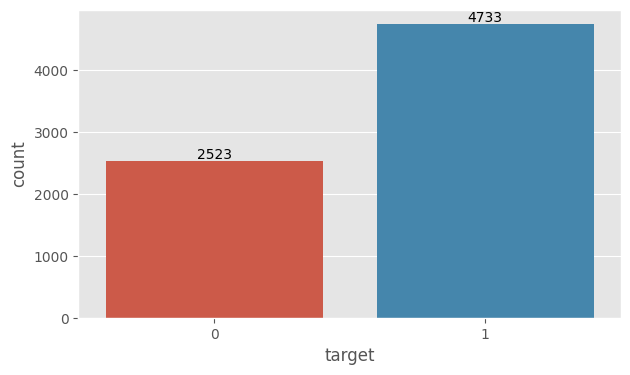

In [50]:
plt.figure(figsize=(7, 4))
ax = sns.countplot(x="target", data=get_df_last_timestep(train_df.copy()))
ax.bar_label(ax.containers[0])
plt.show()

The problem is unbalanced but in the opposite direction. Indeed, generally it is the potives who are in the minority. Our model will therefore tend to predict positives.

This is the reason why as soon as the "class_weight" hyper parameter was set to "balanced", sometimes our model predicted between 1850 (82 class "0") and 1932 (0 class "0") class "1" .

- Balanced the data: by creating two datasets, one with all observations of class "0" and part of observations of class "1" (say half). And the other data set with all observations of the class "0" and the other half obeservations of the class "1". Train the models on it and merge the results. 
By selecting only the last 7 observations of each "NE_ID", we did a kind of undersampling (we decreased the number of zeros that the models could see during training by a factor of about 20 ) , so it is no longer necessary to try to make a .